In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN,GRU,Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from scipy import stats

In [2]:
additional_metrics = ['accuracy']
batch_size = 64
loss_function = categorical_crossentropy
number_of_epochs = 15
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

In [3]:
data=pd.read_csv("DogMoveData.csv",memory_map=True)
data=data.dropna()
data

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
0,16,1,0.00,0.041504,0.938965,-0.015137,-0.067871,-0.510254,-0.934570,-17.639161,-22.766115,7.446290,-7.934571,6.347657,13.427735,<undefined>,<undefined>,<undefined>,<undefined>,<undefined>
1,16,1,0.01,0.041992,0.941895,-0.020020,-0.128906,-0.494141,-0.913086,-15.075685,-11.413575,4.821778,-3.906250,4.394532,16.540528,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
2,16,1,0.02,0.040527,0.939453,-0.004395,-0.158691,-0.480469,-0.911133,-12.207032,-0.122070,2.807617,-0.488281,-1.953125,26.794435,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
3,16,1,0.03,0.021484,0.946289,0.007813,-0.122070,-0.486816,-0.880371,-9.460450,7.995606,1.586914,1.159668,-5.676270,38.085940,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
4,16,1,0.04,-0.000977,0.951172,0.033691,-0.053711,-0.500000,-0.807129,-8.361817,14.587403,-1.037598,4.577637,4.089356,41.503909,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10611063,74,2,1928.19,0.018066,0.436523,0.808105,-0.620605,0.326172,-0.647949,23.620607,75.317387,77.148442,-124.511726,107.727057,-122.497566,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611064,74,2,1928.20,-0.021973,0.515625,0.813965,-0.671875,0.241211,-0.660645,34.729006,63.293461,79.956060,-116.455085,97.534186,-123.229988,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611065,74,2,1928.21,-0.041504,0.507324,0.782227,-0.674805,0.244629,-0.627930,39.978030,49.316409,84.655767,-104.858405,95.458990,-124.816902,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>
10611066,74,2,1928.22,-0.032715,0.484375,0.824219,-0.685059,0.211426,-0.578613,38.024905,32.775881,89.538580,-87.463384,101.257330,-128.601082,Task treat-search,Sniffing,<undefined>,<undefined>,<undefined>


In [4]:
data = data.drop(data[data['Behavior_1'] == '<undefined>'].index)
data=data.drop(data[data['Behavior_1'] == 'Synchronization'].index)
data=data.drop(data[data['Behavior_1'] == 'Extra_Synchronization'].index)
#view updated DataFrame
data=data.drop(['Behavior_2','Behavior_3','PointEvent'],axis=1)
data
l=np.unique(data['Behavior_1'])
l

array(['Bowing', 'Carrying object', 'Drinking', 'Eating', 'Galloping',
       'Jumping', 'Lying chest', 'Pacing', 'Panting', 'Playing',
       'Shaking', 'Sitting', 'Sniffing', 'Standing', 'Trotting',
       'Tugging', 'Walking'], dtype=object)

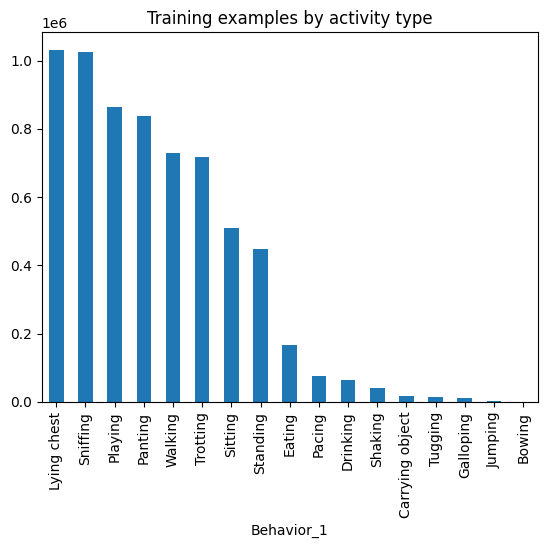

In [5]:
data['Behavior_1'].value_counts().plot(kind='bar', title='Training examples by activity type');


In [6]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(data['Behavior_1'])
 
# printing label
label
data.drop("Behavior_1", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
data["Behavior_1"] = label

In [7]:
data

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1
9081,16,1,90.81,-0.272949,0.204102,1.185547,-0.394043,-0.187500,-0.801270,-39.489749,62.500004,35.766604,-11.718751,52.185062,-75.378423,Task walk,16
9082,16,1,90.82,-0.296875,-0.004883,1.074219,-0.418457,-0.088867,-0.817383,-42.114260,39.794924,44.250491,-5.493164,55.969242,-67.749028,Task walk,16
9083,16,1,90.83,-0.248535,-0.142578,0.994141,-0.440918,-0.052246,-0.799316,-41.564944,12.878419,59.997562,-2.990723,54.016117,-55.236820,Task walk,16
9084,16,1,90.84,-0.170898,-0.216797,0.927246,-0.457520,-0.034668,-0.791504,-34.240725,-14.099122,75.866704,4.333496,47.058108,-38.940432,Task walk,16
9085,16,1,90.85,-0.084473,-0.226563,0.871094,-0.445313,-0.052734,-0.791504,-23.376466,-31.494143,91.247564,13.427735,33.508303,-23.315431,Task walk,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10611063,74,2,1928.19,0.018066,0.436523,0.808105,-0.620605,0.326172,-0.647949,23.620607,75.317387,77.148442,-124.511726,107.727057,-122.497566,Task treat-search,12
10611064,74,2,1928.20,-0.021973,0.515625,0.813965,-0.671875,0.241211,-0.660645,34.729006,63.293461,79.956060,-116.455085,97.534186,-123.229988,Task treat-search,12
10611065,74,2,1928.21,-0.041504,0.507324,0.782227,-0.674805,0.244629,-0.627930,39.978030,49.316409,84.655767,-104.858405,95.458990,-124.816902,Task treat-search,12
10611066,74,2,1928.22,-0.032715,0.484375,0.824219,-0.685059,0.211426,-0.578613,38.024905,32.775881,89.538580,-87.463384,101.257330,-128.601082,Task treat-search,12


In [8]:
N_TIME_STEPS = 70
N_FEATURES = 12
step = 20
segments = []
labels = []
for i in range(0, len(data) - N_TIME_STEPS, step):
    x1 = data['ABack_x'].values[i: i + N_TIME_STEPS]
    y1 = data['ABack_y'].values[i: i + N_TIME_STEPS]
    z1 = data['ABack_z'].values[i: i + N_TIME_STEPS]
    x2 = data['ANeck_x'].values[i: i + N_TIME_STEPS]
    y2 = data['ANeck_y'].values[i: i + N_TIME_STEPS]
    z2 = data['ANeck_z'].values[i: i + N_TIME_STEPS]
    x3 = data['GBack_x'].values[i: i + N_TIME_STEPS]
    y3 = data['GBack_y'].values[i: i + N_TIME_STEPS]
    z3 = data['GBack_z'].values[i: i + N_TIME_STEPS]
    x4 = data['GNeck_x'].values[i: i + N_TIME_STEPS]
    y4 = data['GNeck_y'].values[i: i + N_TIME_STEPS]
    z4 = data['GNeck_z'].values[i: i + N_TIME_STEPS]

    label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]
    segments.append([x1, y1, z1,x2, y2, z2,x3, y3, z3,x4, y4, z4])
    labels.append(label)

C:\Users\karee\AppData\Local\Temp\ipykernel_24820\1107013484.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]


In [9]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [10]:

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3)

In [11]:
reshaped_segments.shape

(327838, 70, 12)

In [12]:
model = Sequential()
model.add(SimpleRNN(units=128, input_shape=(N_TIME_STEPS, N_FEATURES), return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(32))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=17, activation='softmax'))

In [13]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 70, 128)           18048     
                                                                 
 dropout (Dropout)           (None, 70, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 70, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 70, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4

In [15]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

Epoch 1/15
2869/2869 [==============================] - 617s 214ms/step - loss: 1.5700 - accuracy: 0.4034 - val_loss: 1.3969 - val_accuracy: 0.4796
Epoch 2/15
2869/2869 [==============================] - 567s 198ms/step - loss: 1.4430 - accuracy: 0.4590 - val_loss: 1.3941 - val_accuracy: 0.4801
Epoch 3/15
2869/2869 [==============================] - 666s 232ms/step - loss: 1.4053 - accuracy: 0.4739 - val_loss: 1.3482 - val_accuracy: 0.5011
Epoch 4/15
2869/2869 [==============================] - 672s 234ms/step - loss: 1.3770 - accuracy: 0.4864 - val_loss: 1.3586 - val_accuracy: 0.4905
Epoch 5/15
2869/2869 [==============================] - 574s 200ms/step - loss: 1.3753 - accuracy: 0.4861 - val_loss: 1.3023 - val_accuracy: 0.5110
Epoch 6/15
2869/2869 [==============================] - 549s 192ms/step - loss: 1.4117 - accuracy: 0.4727 - val_loss: 1.5298 - val_accuracy: 0.4293
Epoch 7/15
2869/2869 [==============================] - 629s 219ms/step - loss: 1.3815 - accuracy: 0.4816 - val_

In [16]:
test_results = model.evaluate(X_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
model.save("RNNFINALmodel")

Test results - Loss: 1.2962982654571533 - Accuracy: 51.415324211120605%
INFO:tensorflow:Assets written to: RNNFINALmodel\assets


3074/3074 [==============================] - 95s 31ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
(17, 17)


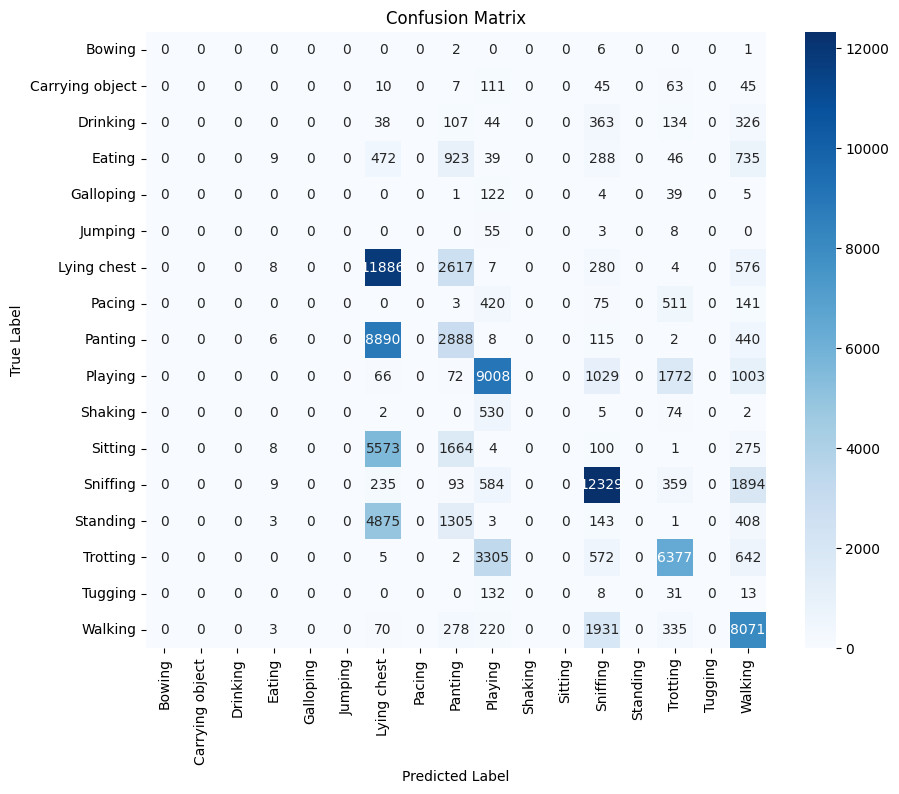

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


rmodel=load_model("RNNFINALmodel")
y_pred = np.argmax(rmodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_test)
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)

#[s[i] for i in y_true]
#unique_classes=['Walking','Standing','Jumping','Tugging','Carrying object','Galloping','Drinking','Panting','Playing','Shaking','Lying chest','Pacing','Trotting','Sitting','Bowing']
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, columns=l, index=l)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred,average='macro')*100

# Calculate recall
recall = recall_score(y_true, y_pred,average='macro')*100

# Calculate F1 score
f1 = f1_score(y_true, y_pred,average='macro')*100

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)*100


print(precision)
print(recall)
print(f1)
print(accuracy)

19.95877298753168
22.50608641085624
20.135443954656672
51.41532454856027


C:\Users\karee\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
